In [1]:
import sys
!{sys.executable} -m pip install test_utils
!{sys.executable} -m pip install imageio
# !{sys.executable} -m pip install tensorflow==2.16.1


  Preparing metadata (setup.py) ... done
  Created wheel for test_utils: filename=test_utils-0.1.0-py3-none-any.whl size=3835 sha256=5bd34c72acc59051b5ae13866442f964057a7717d10aa994264e1dbcabfd5849
  Stored in directory: /root/.cache/pip/wheels/2d/bd/72/4b0b1b86681b3175adfe4b58a07d4eea9b505cad6b08b65121
Successfully built test_utils


In [2]:
import tensorflow as tf
import numpy as np
import os
import zipfile
import shutil
import pandas as pd
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

print(tf.__version__)


2.18.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Define a dataset path
dataset = r'/content/drive/MyDrive/PROJECT/Dicoding Project/IDCAMP - Project II - Image Classification/dataset/brain_cancer_dataset.zip'
base_dir = r'/content/drive/MyDrive/PROJECT/Dicoding Project/IDCAMP - Project II - Image Classification/dataset'

# Define a path for training and validation set
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

labels = ['glioma', 'meningioma', 'pituitary']

# # UnZIP
# with zipfile.ZipFile(dataset, 'r') as zip_ref:
#     zip_ref.extractall(base_dir)

# Define a path for each label
glioma_dir = os.path.join(base_dir, 'glioma')
meningioma_dir = os.path.join(base_dir, 'meningioma')
pituitary_dir = os.path.join(base_dir, 'pituitary')

In [5]:
train_glioma_dir, val_glioma_dir = train_test_split(os.listdir(glioma_dir), test_size=0.4, random_state=42)
train_meningioma_dir, val_meningioma_dir = train_test_split(os.listdir(meningioma_dir), test_size=0.4, random_state=42)
train_pituitary_dir, val_pituitary_dir = train_test_split(os.listdir(pituitary_dir), test_size=0.4, random_state=42)

val_glioma_dir, test_glioma_dir = train_test_split(val_glioma_dir, test_size=0.5, random_state=42)
val_meningioma_dir, test_meningioma_dir = train_test_split(val_meningioma_dir, test_size=0.5, random_state=42)
val_pituitary_dir, test_pituitary_dir = train_test_split(val_pituitary_dir, test_size=0.5, random_state=42)

In [6]:
# Create a training and validation folder
os.makedirs(os.path.join(train_dir, 'glioma'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'meningioma'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'pituitary'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'glioma'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'meningioma'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'pituitary'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'glioma'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'meningioma'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'pituitary'), exist_ok=True)

In [7]:
# Move images into training and validation set folder
def copy_images(filenames, source_dir, des_dir):
    for file in filenames:
        source = os.path.join(source_dir, file)
        des = os.path.join(des_dir, file)
        copyfile(source, des)

# copy_images(train_glioma_dir, glioma_dir, os.path.join(train_dir, 'glioma'))
# copy_images(train_meningioma_dir, meningioma_dir, os.path.join(train_dir, 'meningioma'))
# copy_images(train_pituitary_dir, pituitary_dir, os.path.join(train_dir, 'pituitary'))
# copy_images(val_glioma_dir, glioma_dir, os.path.join(val_dir, 'glioma'))
# copy_images(val_meningioma_dir, meningioma_dir, os.path.join(val_dir, 'meningioma'))
# copy_images(val_pituitary_dir, pituitary_dir, os.path.join(val_dir, 'pituitary'))
# copy_images(test_glioma_dir, glioma_dir, os.path.join(test_dir, 'glioma'))
# copy_images(test_meningioma_dir, meningioma_dir, os.path.join(test_dir, 'meningioma'))
# copy_images(test_pituitary_dir, pituitary_dir, os.path.join(test_dir, 'pituitary'))

In [8]:
# Implement image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.2, 1.2]
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [9]:
# Define batch size and traget size
batch_size = 64
target_size = (224, 224)
input_shape = (224, 224, 3)

In [10]:
# Utilize image data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9000 images belonging to 3 classes.
Found 3010 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [11]:
# Load the EfficientNetB0 model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
# base_model.trainable = True

model = tf.keras.Sequential([
    # Base EfficientNet model
    base_model,
    Conv2D(256, (1, 1), activation='linear'),
    BatchNormalization(),
    MaxPooling2D(1, 1),
    GlobalAveragePooling2D(),
    # Output layer
    Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 7, 7, 256)           │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,302 (16.71 MB)

 Trainable params: 4,336,767 (16.54 MB)

 Non-trainable params: 42,535 (166.16 KB)

In [12]:
#early stopping to monitor the validation loss in order to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode = 'min',
                           verbose=1, patience =10, restore_best_weights = True)

#reducing the learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode = 'min', patience=5 , factor = 0.5, min_lr= 1e-6, verbose =1)

callbacks = [early_stop, rlrop]

In [14]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    batch_size=batch_size
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3064s 22s/step - accuracy: 0.5598 - loss: 0.9332 - val_accuracy: 0.3322 - val_loss: 1.2086 - learning_rate: 1.0000e-05
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8602 - loss: 0.4346 - val_accuracy: 0.3452 - val_loss: 1.1129 - learning_rate: 1.0000e-05
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9033 - loss: 0.2969 - val_accuracy: 0.5545 - val_loss: 0.9612 - learning_rate: 1.0000e-05
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9237 - loss: 0.2310 - val_accuracy: 0.7814 - val_loss: 0.6289 - learning_rate: 1.0000e-05
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3060s 22s/step - accuracy: 0.9318 - loss: 0.2022 - val_accuracy: 0.6309 - val_loss: 0.8526 - learning_rate: 1.0000e-05
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.9428 - loss: 0.1687 - val_accuracy: 0.7817 - val_loss: 0.5716 - learning_rate: 1.0000e-05
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step -

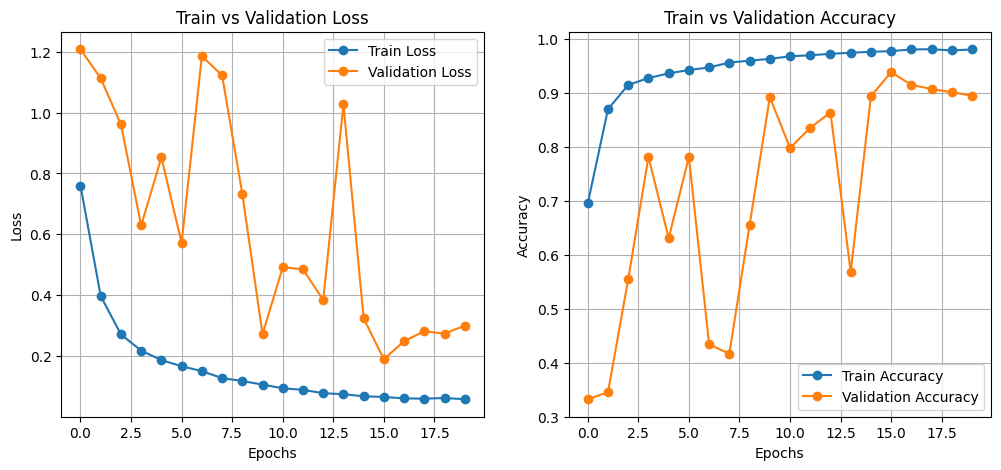

In [15]:
# Extract loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid()

plt.show()


# Test Model

In [16]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=batch_size)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 943s 20s/step - accuracy: 0.9598 - loss: 0.1437
Test Loss: 0.1712
Test Accuracy: 0.9507


# Save Model

In [21]:
model.export("model")

Saved artifact at 'model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138566453543952: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138566453543760: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138566585621328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585620944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566617827664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585620176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585623248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138

In [22]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

print("Model berhasil dikonversi ke TensorFlow Lite")

Saved artifact at '/tmp/tmp8_12_sm2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138566453543952: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138566453543760: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  138566585621328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585621712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585620944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566617827664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585622672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585620176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138566585623248: TensorSpec(shape=(), dtype=tf.resource, name=

In [23]:
!pip install tensorflowjs
import tensorflowjs as tfjs

# Simpan model dalam format TensorFlow.js
tfjs.converters.save_keras_model(model, "model_tfjs")

print("Model berhasil dikonversi ke TensorFlow.js")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 25.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32
Model berhasil dikonversi ke TensorFlow.js


In [24]:
import shutil
from google.colab import files

## Kompres folder /content/model menjadi model.zip
shutil.make_archive('/content/model', 'zip', '/content/model')

# Download file ZIP
files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
shutil.make_archive('/content/model_tfjs', 'zip', '/content/model_tfjs')
# Download file ZIP
files.download('/content/model_tfjs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>